In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tftb
import scipy.signal as sig
from csaps import csaps
from sklearn.model_selection import KFold

from utils.preprocessing import load_data,center_data
from utils.plotting import plot_single, plot_setup

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.signal import savgol_filter

In [3]:
df = load_data('./data/Geo_Mag_Vari_Odessa_25-31_Jan_2018.txt')
df['y_centered'] = center_data(df.By)
myfigsize = (14,4)

c:\Users\Admin\diploma\utils\plotting.py:202: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


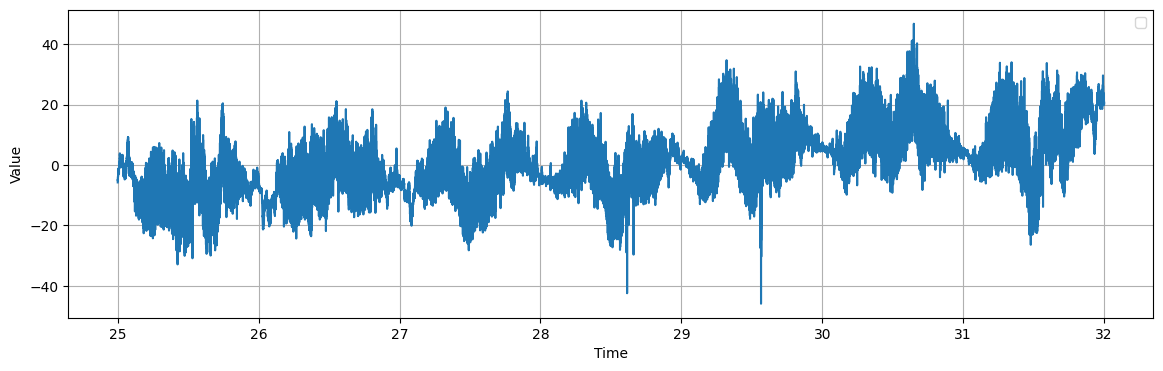

In [4]:
plt.figure(figsize=myfigsize)
plt.plot(df.Time, df.y_centered)
plot_setup()

In [5]:
def smoothing(
    data,
    selected_option: str,
    ord,
    window_size,
):
    """_summary_

    Args:
        option (str): _description_
    """
    
    if (selected_option == 'Savitzky-Golay'):
        return savgol_filter(data, window_length=window_size, polyorder=ord)


In [6]:
def cross_validate_smoothing(x, y, smoothing_values, n_splits=5, shuffle=False, rs=None):
    kf = KFold(n_splits=n_splits, shuffle=shuffle, random_state=rs)
    best_smoothing = None
    best_error = float('inf')
    for s in smoothing_values:
        cv_errors = []
        for train_index, test_index in kf.split(x):
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            y_pred = csaps(x_train, y_train, x_test, smooth=s)
            error = np.mean((y_pred - y_test)**2)
            cv_errors.append(error)
        
        avg_error = np.mean(cv_errors)
        if avg_error < best_error:
            best_error = avg_error
            best_smoothing = s

    return best_smoothing

In [7]:
smoothing_values = np.linspace(0.001, 1.0, 4)
best_smooth = cross_validate_smoothing(df.Time, df.y_centered, smoothing_values, n_splits=10)


KeyboardInterrupt: 

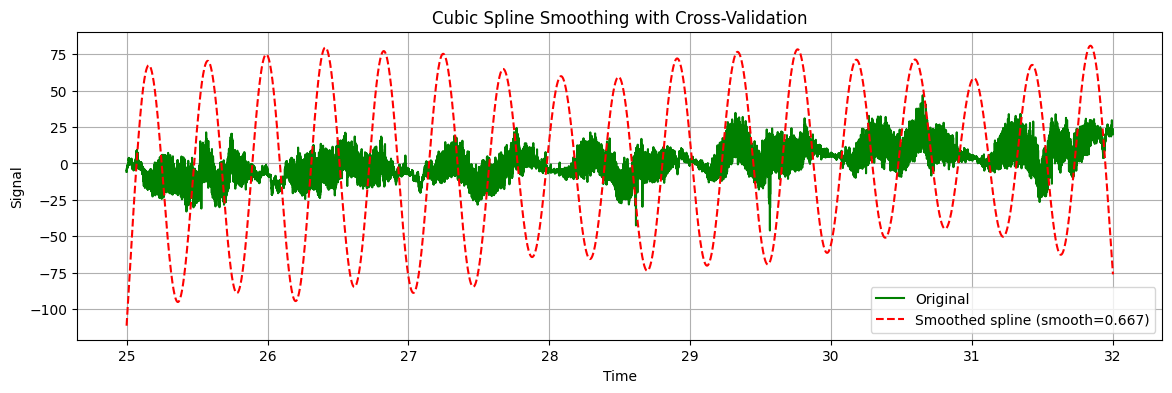

In [ ]:
y_smoothed = csaps(df.Time, df.y_centered, df.Time, smooth=0)
plt.figure(figsize=myfigsize)
plt.plot(df.Time, df.y_centered, color='green', label='Original')
plt.plot(df.Time, y_smoothed, color='red', label=f'Smoothed spline (smooth={best_smooth:.3f})', linestyle='dashed')
plot_setup(
    xlabel='Time',
    ylabel='Signal',
    title='Cubic Spline Smoothing with Cross-Validation'
)

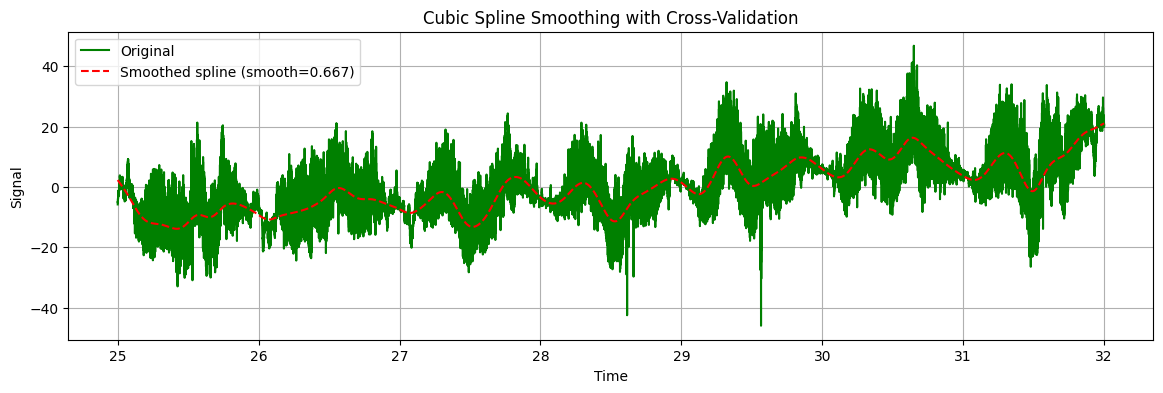

In [ ]:
y_smoothed = csaps(df.Time, df.y_centered, df.Time, smooth=best_smooth)
# y_smoothed = csaps(df.Time, df.y_centered, df.Time, smooth=10000)

# Plot the results
plt.figure(figsize=myfigsize)
plt.plot(df.Time, df.y_centered, color='green', label='Original')
plt.plot(df.Time, y_smoothed, color='red', label=f'Smoothed spline (smooth={best_smooth:.3f})', linestyle='dashed')
plot_setup(
    xlabel='Time',
    ylabel='Signal',
    title='Cubic Spline Smoothing with Cross-Validation'
)

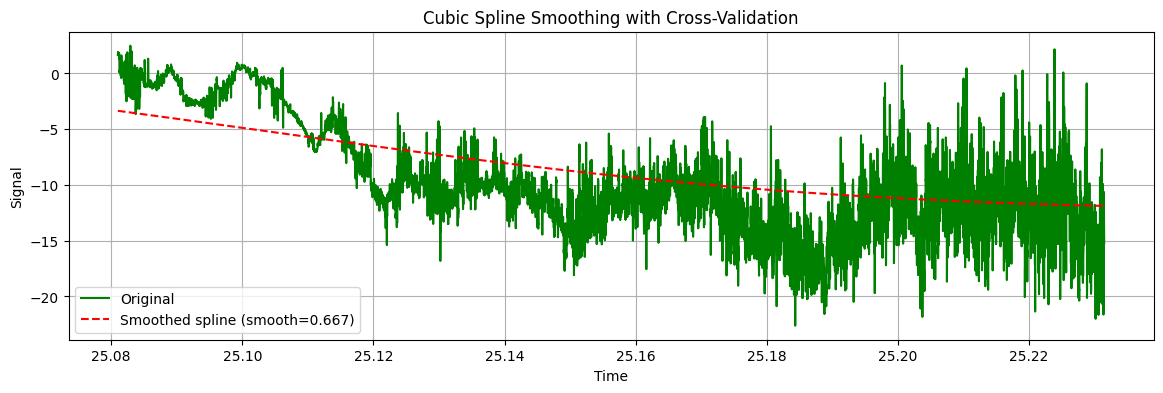

In [ ]:
some_a = 7000
some_b = 20000
plt.figure(figsize=myfigsize)
plt.plot(df.Time[some_a:some_b], df.y_centered[some_a:some_b], color='green', label='Original')
plt.plot(df.Time[some_a:some_b], y_smoothed[some_a:some_b], color='red', label=f'Smoothed spline (smooth={best_smooth:.3f})', linestyle='dashed')
plot_setup(
    xlabel='Time',
    ylabel='Signal',
    title='Cubic Spline Smoothing with Cross-Validation'
)

In [32]:
def tricube_weight(d, bandwidth):
    """Tricube kernel function."""
    u = np.abs(d / bandwidth)
    return (1 - u**3)**3 * (u < 1)

def gaussian_weight(d, bandwidth):
    """Gaussian kernel function."""
    return np.exp(-0.5 * (d / bandwidth)**2)

def loess_smoothing(x, y, x_eval, bandwidth=1, kernel='tricube', degree=1):
    y_smooth = np.zeros_like(x_eval)

    for i, x0 in enumerate(x_eval):
        distances = np.abs(x - x0)
        
        if kernel == 'tricube':
            weights = tricube_weight(distances, bandwidth)
        elif kernel == 'gaussian':
            weights = gaussian_weight(distances, bandwidth)
        else:
            raise ValueError("Unknown kernel")

        W = np.diag(weights)
        X_mat = np.vstack([x**p for p in range(degree + 1)]).T
        XTWX = X_mat.T @ W @ X_mat
        XTWY = X_mat.T @ W @ y

        theta = np.linalg.pinv(XTWX) @ XTWY  # Solve weighted least squares
        y_smooth[i] = sum(theta[p] * x0**p for p in range(degree + 1))

    return y_smooth

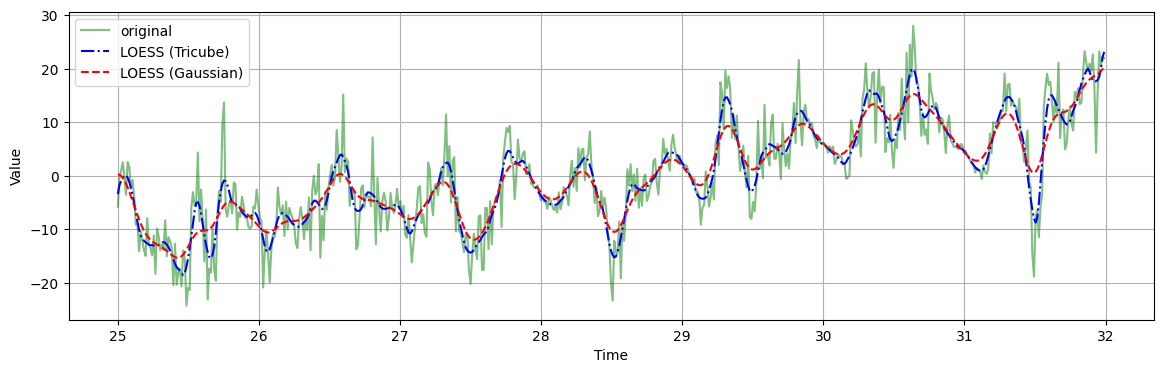

In [ ]:
rate=1000
t=df.Time[::rate]
y = df.y_centered[::rate]

y_loess_tricube = loess_smoothing(t, y, t, bandwidth=0.07, kernel='tricube')
y_loess_gauss = loess_smoothing(t, y, t, bandwidth=0.07, kernel='gaussian')

plt.figure(figsize=myfigsize)
plt.plot(t, y, alpha=0.5, label="original", color='green')
plt.plot(t, y_loess_tricube, label="LOESS (Tricube)", color="blue", linestyle='-.')
plt.plot(t, y_loess_gauss, label="LOESS (Gaussian)", color="red", linestyle="dashed")
plot_setup()

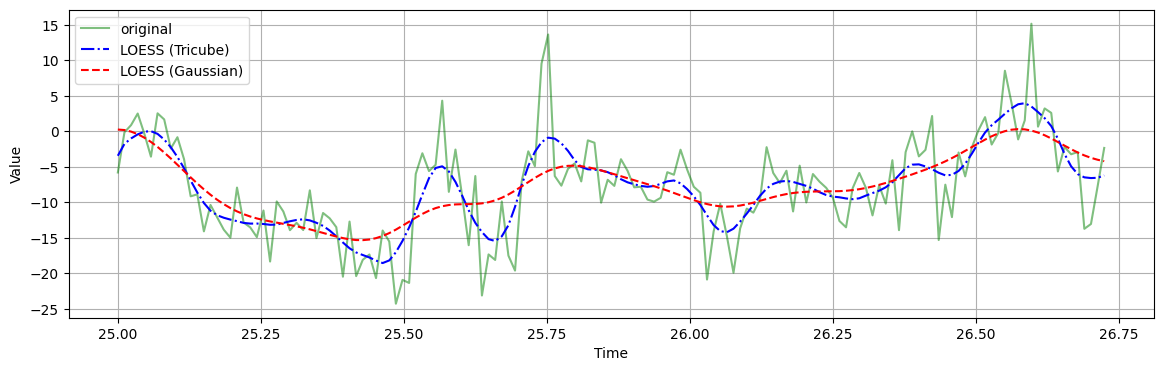

In [ ]:
plt.figure(figsize=myfigsize)
some_a = 0
some_b = 150
plt.plot(t[some_a:some_b], y[some_a:some_b], alpha=0.5, label="original", color='green')
plt.plot(t[some_a:some_b], y_loess_tricube[some_a:some_b], label="LOESS (Tricube)", color="blue", linestyle='-.')
plt.plot(t[some_a:some_b], y_loess_gauss[some_a:some_b], label="LOESS (Gaussian)", color="red", linestyle="dashed")
plot_setup()

In [ ]:
df = load_data('./data/GeoMag Odessa-Finland/01-Jun-2018 Nurmijarvi GeoMag.txt')
from utils.preprocessing import *

# df = drop_value(df, 'Bx')
df = drop_value(df, 'By')
df['Byc'] = center_data(df.By)



In [49]:
rate=50
some_a = 0
some_b = 200
t = df.Time[::rate][some_a:some_b]
y = df.Byc[::rate][some_a:some_b]

In [50]:
window_size = 17
ord = 3
sg = savgol_filter(y, window_length=window_size, polyorder=ord)

In [65]:
bandwidth = 0.03
y_loess_tricube = loess_smoothing(t, y, t, bandwidth=bandwidth, kernel='tricube')
y_loess_gauss = loess_smoothing(t, y, t, bandwidth=bandwidth, kernel='gaussian')
y_loess_tricube = loess_smoothing(t, y, t, bandwidth=bandwidth, kernel='tricube')

In [86]:
from scipy.interpolate import UnivariateSpline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

x = t         # e.g., time
# y = signal    # e.g., measured noisy values

lambdas = np.logspace(-2, 2, 50)
kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_errors = []

for lam in lambdas:
    errors = []
    for train_idx, test_idx in kf.split(x):
        x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
        x_test, y_test = x.iloc[test_idx], y.iloc[test_idx]

        spline = UnivariateSpline(x_train, y_train, s=lam)
        y_pred = spline(x_test)
        errors.append(mean_squared_error(y_test, y_pred))
    
    cv_errors.append(np.mean(errors))

best_lambda = lambdas[np.argmin(cv_errors)]
best_spline = UnivariateSpline(x, y, s=best_lambda)


In [114]:
smoothing_values = np.logspace(-2, 2, 100)
best_smooth = cross_validate_smoothing(np.array(t), np.array(y), smoothing_values, n_splits=2)
y_smoothed = csaps(t, y, t, smooth=0.999)
print(f"Best smoothing value: {best_smooth:.3f}")

Best smoothing value: 0.870


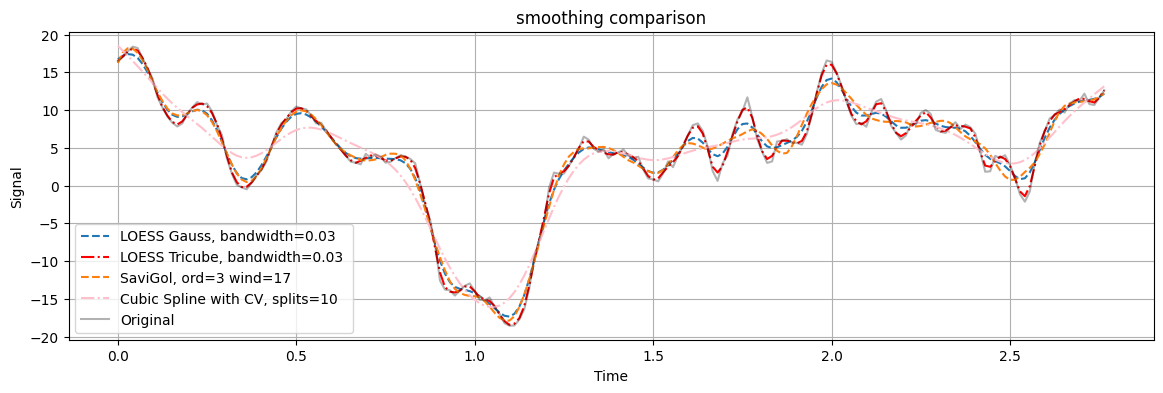

In [117]:
plt.figure(figsize=myfigsize)

plt.plot(t, y_loess_gauss, label=f'LOESS Gauss, {bandwidth=} ', linestyle='dashed', alpha=1.0)
plt.plot(t, y_loess_tricube, color='red', label=f'LOESS Tricube, {bandwidth=} ', linestyle='-.', alpha=1.0)
plt.plot(t, sg, label=f'SaviGol, {ord=} wind={window_size}', linestyle='dashed', alpha=1.0)
# plt.plot(t, best_spline(x), color='pink', label='Cubic Spline with CV', linestyle='-.', alpha=1.)
plt.plot(t, y_smoothed, color='pink', label=f'Cubic Spline with CV, splits={10}', linestyle='-.', alpha=1.)
plt.plot(t, y, color='black', label='Original', alpha=0.3)

plot_setup(
    xlabel='Time',
    ylabel='Signal',
    title='smoothing comparison',
)